Prepare the data
Check the data and its stationarity

In [131]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima import auto_arima

In [132]:
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
stock_data = pd.read_excel("C:/Users/ROG/Desktop/so this is the sadness/MINI Project/Data/candlestick_chart_data.xlsx", index_col='Date', parse_dates=['Date'])
pd.set_option('display.max_columns', None)
print(stock_data)

            Opening price  Highest price  Lowest price  Closing price  \
Date                                                                    
2025-01-02            267            303           243            288   
2025-01-03            281            317           270            291   
2025-01-06            278            346           276            327   
2025-01-07            336            388           317            369   
2025-01-08            365            374           303            311   
...                   ...            ...           ...            ...   
2025-06-25             96            114            93            104   
2025-06-26            113            114            94            111   
2025-06-27            106            113            93            111   
2025-06-30            103            113            93            110   
2025-07-01             94            114            93            107   

            Trading volume  Turnover  Median price

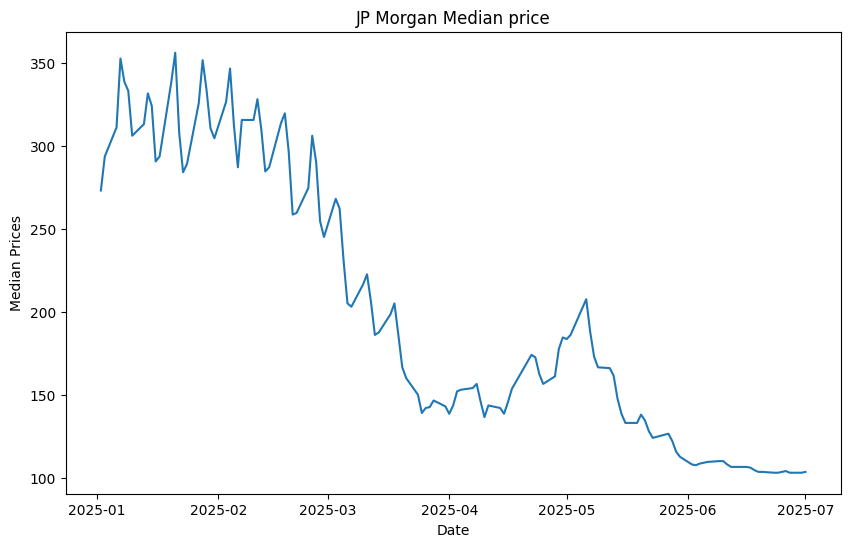

In [133]:
#Visualize the per day closing price of the stock.
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Median Prices')
plt.plot(stock_data['Median price'])
plt.title('JP Morgan Median price')
plt.show()


<Axes: ylabel='Density'>

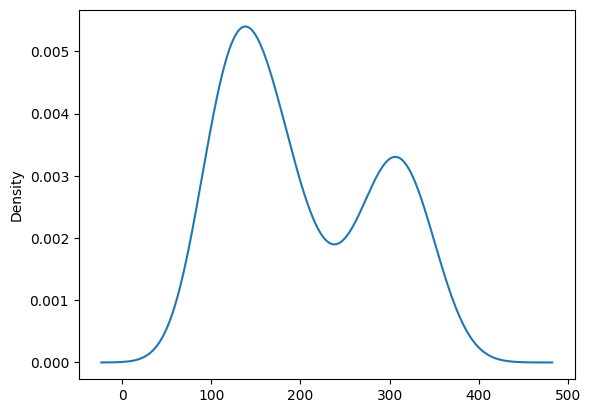

In [134]:
# Distribution of the dataset
df_Median=stock_data['Median price']
df_Median.plot(kind='kde')

In [135]:
#Using the ADF test to check if a series is stationary or not because time series analysis only works with stationary data
def test_stationarity(timeseries):
    print("Results for dickey fuller test")
    results=adfuller(timeseries, autolag='AIC')
    output=pd.Series(results[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in results[4].items():
        output['critical value (%s)'%key] =values
    print(output)

In [136]:
test_stationarity(df_Median)

Results for dickey fuller test
Test Statistics                 -1.197946
p-value                          0.674478
No. of lags used                11.000000
Number of observations used    113.000000
critical value (1%)             -3.489590
critical value (5%)             -2.887477
critical value (10%)            -2.580604
dtype: float64


Text(0.5, 1.0, '2 order differencing')

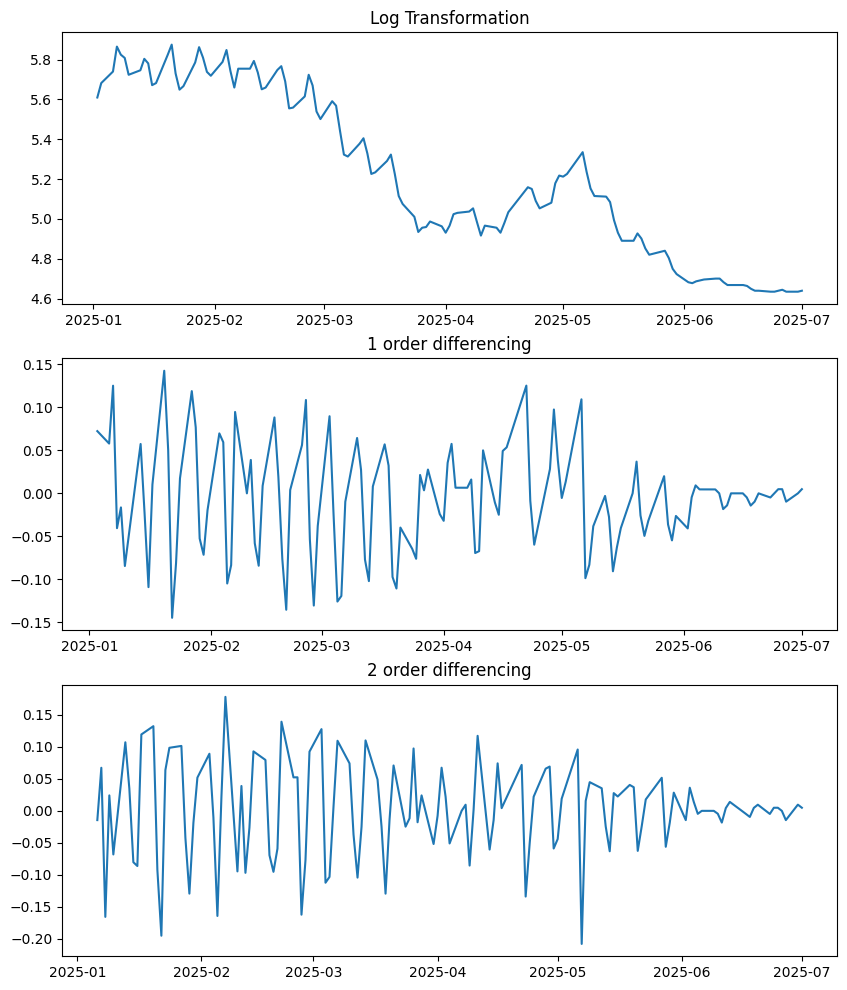

In [137]:
# # Nomalization
# avg, dev=df_close.mean(),df_close.std()
# df_nomal=(df_close-avg)/dev
# df_nomal.plot()
# # Log transformation
df_log=np.log(df_Median)
fig,axe = plt.subplots(3,1, figsize=(10,12))
axe[0].plot(df_log)
axe[0].set_title('Log Transformation')
# Take first difference to remove the trend
df_diff=df_log.diff().dropna()
axe[1].plot(df_diff)
axe[1].set_title('1 order differencing')

df_diff_2=df_diff.diff().dropna()
axe[2].plot(df_diff_2)
axe[2].set_title('2 order differencing')

In [138]:
test_stationarity(df_diff)

Results for dickey fuller test
Test Statistics                 -4.422442
p-value                          0.000271
No. of lags used                 4.000000
Number of observations used    119.000000
critical value (1%)             -3.486535
critical value (5%)             -2.886151
critical value (10%)            -2.579896
dtype: float64


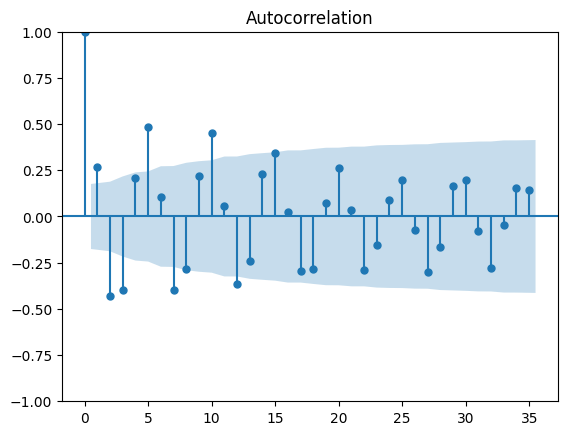

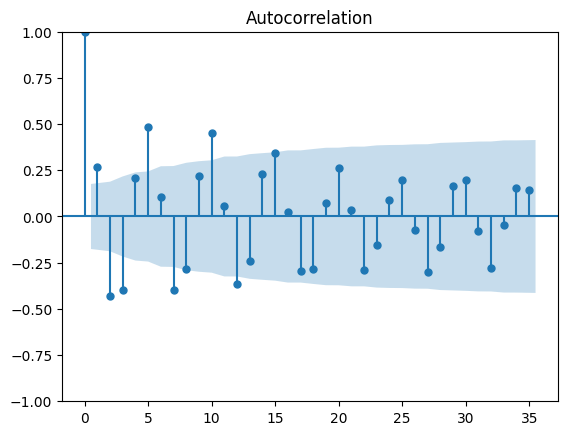

In [139]:
n_lags=35
plot_acf(df_diff,lags=n_lags, alpha=0.05)

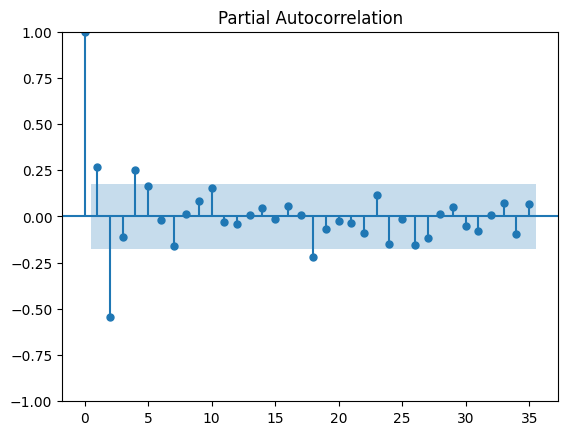

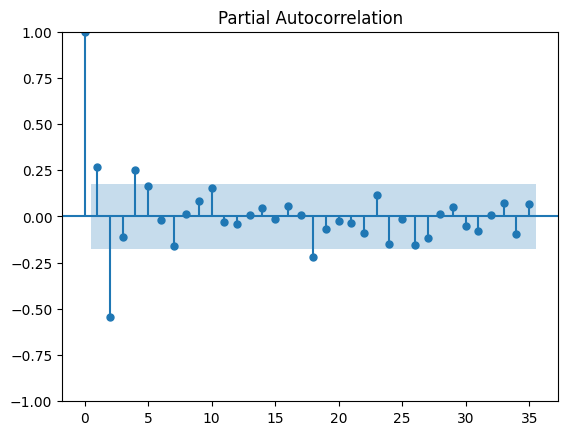

In [140]:
plot_pacf(df_diff,lags=n_lags)

Split data

In [141]:
def train_test_split(df,size=0.9):
    train_data, test_data=df[:int(len(df)*size)], df[int(len(df)*size):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(df,'green', label='Train data')
    plt.plot(test_data, 'blue', label='Test data')
    plt.legend()
    return train_data, test_data

DatetimeIndex(['2025-01-02', '2025-01-03', '2025-01-06', '2025-01-07',
               '2025-01-08', '2025-01-09', '2025-01-10', '2025-01-13',
               '2025-01-14', '2025-01-15',
               ...
               '2025-06-18', '2025-06-19', '2025-06-20', '2025-06-23',
               '2025-06-24', '2025-06-25', '2025-06-26', '2025-06-27',
               '2025-06-30', '2025-07-01'],
              dtype='datetime64[ns]', name='Date', length=125, freq=None)


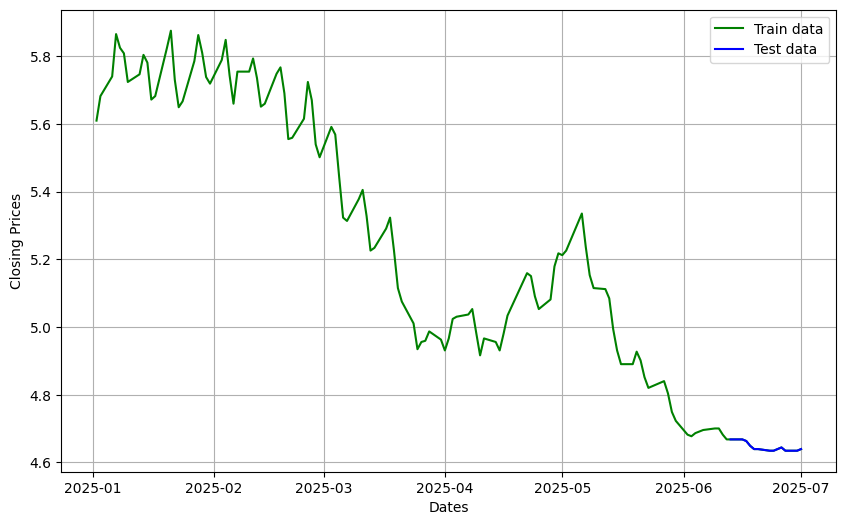

In [142]:
print(df_log.index)
train_data,test_data=train_test_split(df_log, 0.9)

In [143]:
train_data

Date
2025-01-02    5.609472
2025-01-03    5.681878
2025-01-06    5.739793
2025-01-07    5.865051
2025-01-08    5.824524
                ...   
2025-06-06    4.695925
2025-06-09    4.700480
2025-06-10    4.700480
2025-06-11    4.682131
2025-06-12    4.668145
Name: Median price, Length: 112, dtype: float64

In [144]:
test_data

Date
2025-06-13    4.668145
2025-06-16    4.668145
2025-06-17    4.663439
2025-06-18    4.649187
2025-06-19    4.639572
2025-06-20    4.639572
2025-06-23    4.634729
2025-06-24    4.634729
2025-06-25    4.639572
2025-06-26    4.644391
2025-06-27    4.634729
2025-06-30    4.634729
2025-07-01    4.639572
Name: Median price, dtype: float64

Model Selection

C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, b

AIC for ARIMA(1,1,1):-311.34607812739534
AIC for ARIMA(1,1,2):-314.577496454399
AIC for ARIMA(1,1,3):-320.6941697968924
AIC for ARIMA(1,1,4):-324.42668551674996
AIC for ARIMA(1,1,5):-325.9071469172948
AIC for ARIMA(2,1,1):-331.81638612408636
AIC for ARIMA(2,1,2):-343.03205314696464
AIC for ARIMA(2,1,3):-345.7678698609877
AIC for ARIMA(2,1,4):-344.3292817079174
AIC for ARIMA(2,1,5):-342.33722447797277
AIC for ARIMA(3,1,1):-332.4336705023158
AIC for ARIMA(3,1,2):-346.28904606939983
AIC for ARIMA(3,1,3):-344.279475841152
AIC for ARIMA(3,1,4):-342.41634639823064
AIC for ARIMA(3,1,5):-341.02918345984835
AIC for ARIMA(4,1,1):-340.07520407375506
AIC for ARIMA(4,1,2):-337.72482121983035
AIC for ARIMA(4,1,3):-342.4278717533296
AIC for ARIMA(4,1,4):-339.42022814810275
AIC for ARIMA(4,1,5):-339.49973280024864
AIC for ARIMA(5,1,1):-339.3352123318307
AIC for ARIMA(5,1,2):-338.41399781590354
AIC for ARIMA(5,1,3):-340.9121450319497
AIC for ARIMA(5,1,4):-339.4190786198742
AIC for ARIMA(5,1,5):-337.635

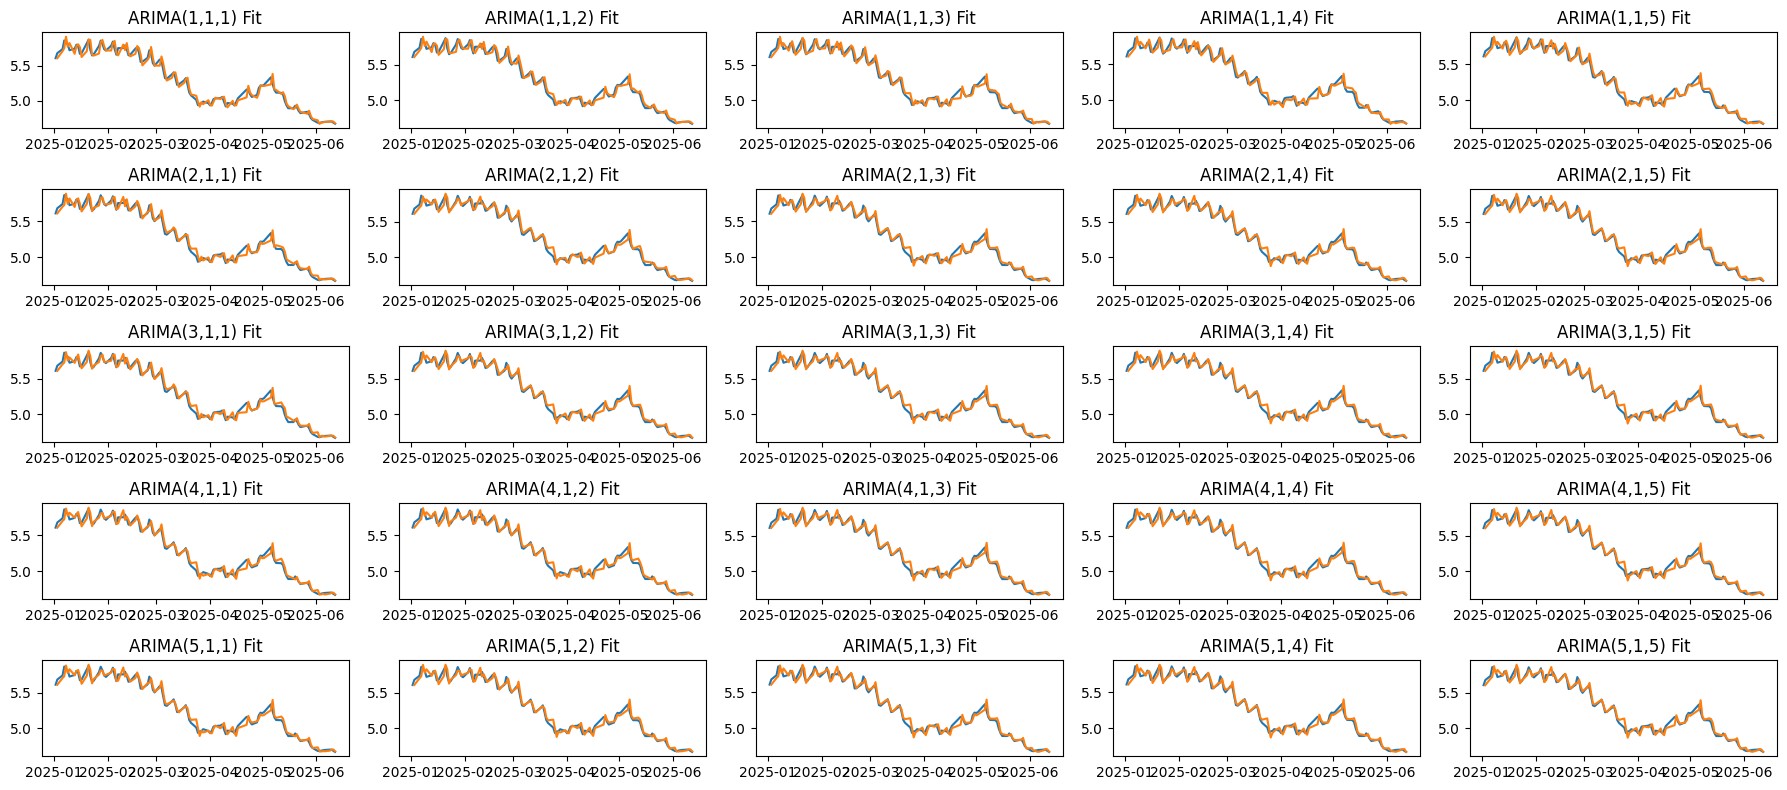

In [145]:
# model selection
ar_orders=[1,2,3,4,5]
ma_orders=[1,2,3,4,5]
fitted_model_dict={}
AIC_dict={}
fig,axes=plt.subplots(len(ar_orders),len(ma_orders),figsize=(18,8))
for idx, ar_order in enumerate(ar_orders):
    for idy, ma_order in enumerate(ma_orders):
        # create ARIMA model
        model=ARIMA(train_data, order=(ar_order,1,ma_order))
        model_fit = model.fit()
        fitted_model_dict[ar_order,ma_order]=model_fit
        AIC_dict[ar_order,ma_order]=fitted_model_dict[ar_order,ma_order].aic
        ax = axes[idx, idy]
        ax.set_title('ARIMA(%s,1,%s) Fit'%(ar_order,ma_order))
        ax.plot(train_data)
        ax.plot(model_fit.fittedvalues[1:])
plt.tight_layout()
for ar_order in ar_orders:
    for ma_order in ma_orders:
        print('AIC for ARIMA(%s,1,%s):%s'%(ar_order,ma_order,AIC_dict[ar_order,ma_order]))

In [146]:
# Sort the dictionary by value and return the first key-value pair
min_key, min_val = sorted(AIC_dict.items(), key=lambda x: x[1])[0]
print("The ARIMA model with the lowest AIC is: (%s,1,%s)"%(min_key[0],min_key[1]))

The ARIMA model with the lowest AIC is: (3,1,2)


Type Markdown and $$Latex:\alpha^{2}$$

Figure(1500x800)


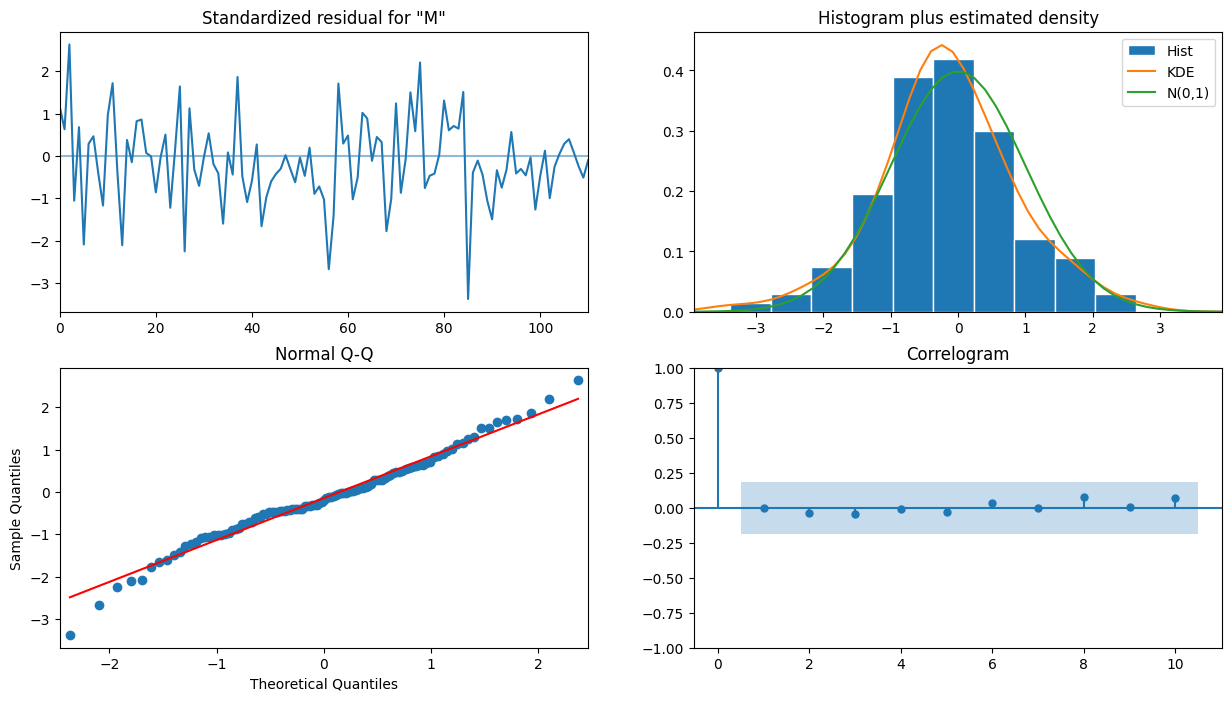

In [147]:
print(fitted_model_dict[min_key[0],min_key[1]].plot_diagnostics(figsize=(15,8)))

Test the data

Date
2025-01-02    5.609472
2025-01-03    5.681878
2025-01-06    5.739793
2025-01-07    5.865051
2025-01-08    5.824524
                ...   
2025-06-06    4.695925
2025-06-09    4.700480
2025-06-10    4.700480
2025-06-11    4.682131
2025-06-12    4.668145
Name: Median price, Length: 112, dtype: float64
Date
2025-01-02    0.000000
2025-01-03    5.609472
2025-01-06    5.701829
2025-01-07    5.727701
2025-01-08    5.879346
                ...   
2025-06-06    4.676917
2025-06-09    4.696344
2025-06-10    4.712040
2025-06-11    4.706540
2025-06-12    4.672874
Length: 112, dtype: float64


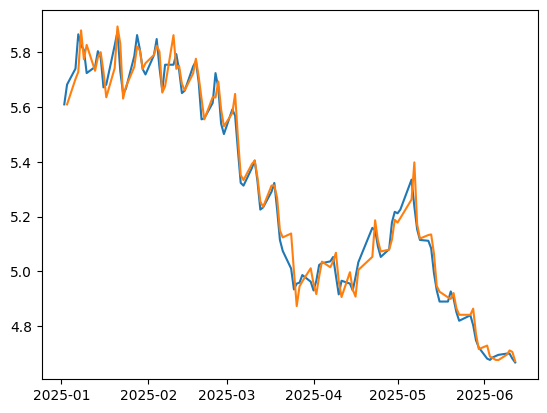

In [148]:
model_fit=fitted_model_dict[min_key[0],min_key[1]]
#model_fit=fitted_model_dict[3,2]
#get the predictions and residuals
predictions=model_fit.fittedvalues
# residuals = test_data - predictions
print(train_data)
print(predictions)
plt.plot(train_data)
plt.plot(predictions[1:])

In [149]:
pre_test=model_fit.forecast(steps=len(test_data))
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
print(pre_test)

112    4.661607
113    4.662327
114    4.665997
115    4.666467
116    4.662933
117    4.660307
118    4.662078
119    4.665587
120    4.665958
121    4.662852
122    4.660684
123    4.662356
124    4.665386
Name: predicted_mean, dtype: float64


C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [150]:
fc_series = pd.Series(np.array(pre_test), index=test_data.index)
fc_series

Date
2025-06-13    4.661607
2025-06-16    4.662327
2025-06-17    4.665997
2025-06-18    4.666467
2025-06-19    4.662933
2025-06-20    4.660307
2025-06-23    4.662078
2025-06-24    4.665587
2025-06-25    4.665958
2025-06-26    4.662852
2025-06-27    4.660684
2025-06-30    4.662356
2025-07-01    4.665386
dtype: float64

<Axes: xlabel='Date'>

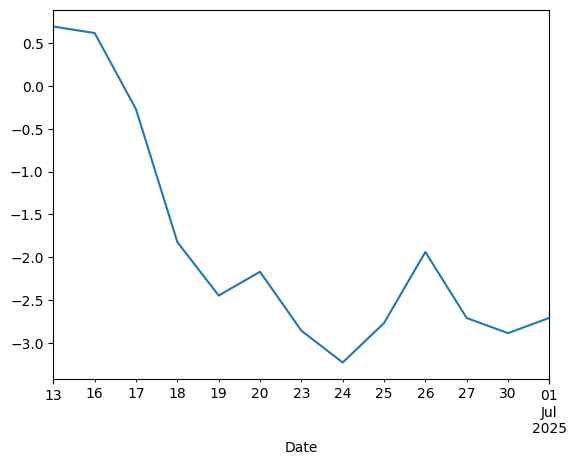

In [151]:
residuals=np.exp(test_data)-np.exp(fc_series)
residuals.plot()

RMSE: 2.2856641378440994
MAPE: 0.020137664152531175


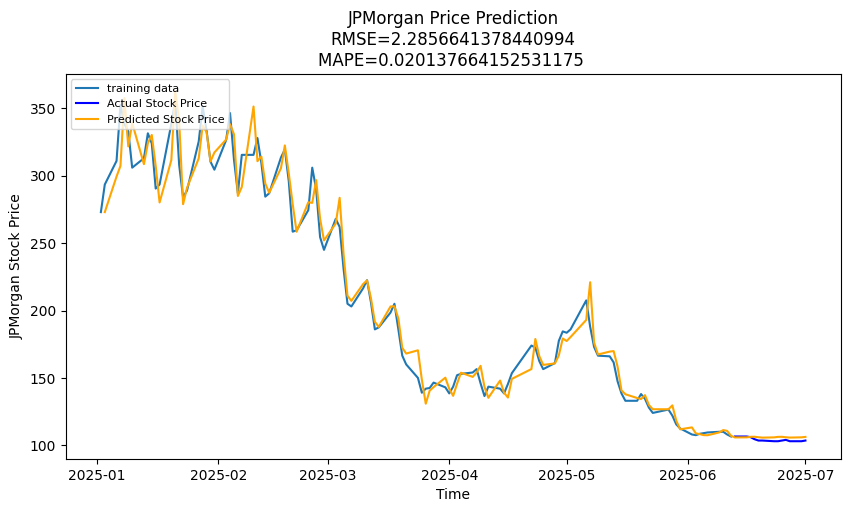

In [152]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
concat_df=[predictions[1:],fc_series]
pred_df=pd.concat(concat_df)
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(np.exp(pred_df), color = 'orange',label='Predicted Stock Price')
#plt.fillbetween(test_data.index, lower_series, upper_series, color='k', alpha=.15)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_series)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(residuals)/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))
plt.title('JPMorgan Price Prediction\nRMSE=%s\nMAPE=%s '%(str(rmse),str(mape)))
plt.xlabel('Time')
plt.ylabel('JPMorgan Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Using Auto-ARIMA Model

Rolling Forecasting Origin

In [153]:
# create the model 
from datetime import timedelta
predictions_rolling=pd.Series(dtype=float)
for end_date in test_data.index:
    train_data=df_log[:end_date-timedelta(days=1)]
    model=auto_arima(train_data, seasonal=False,stepwise=True,suppress_warnings=True,error_action='ignore',max_order=None,trace=False)
    pred = model.predict(n_periods=1)
    predictions_rolling.loc[end_date]=pred.values[0]
print(model.summary())

C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next vers

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  124
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 206.055
Date:                Tue, 12 Mar 2024   AIC                           -398.110
Time:                        02:08:10   BIC                           -378.425
Sample:                             0   HQIC                          -390.114
                                - 124                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0076      0.005     -1.545      0.122      -0.017       0.002
ar.L1          0.8843      0.143      6.196      0.000       0.605       1.164
ar.L2         -1.1283      0.080    -14.062      0.0

C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


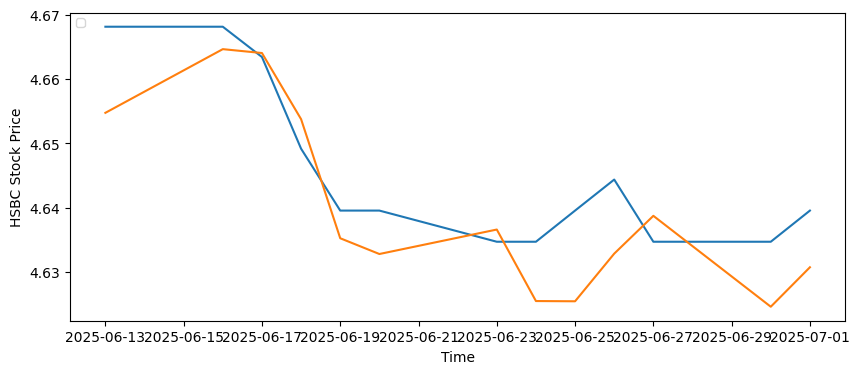

In [154]:
# draw the prediction plot
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions_rolling)

plt.xlabel('Time')
plt.ylabel('JP Morgan Stock Price')
plt.legend(loc='upper left', fontsize=8)

In [155]:
residuals_rolling=np.exp(test_data)-np.exp(predictions_rolling) # get the residuals
print(residuals_rolling)
print(predictions_rolling)

Date
2025-06-13    1.415715
2025-06-16    0.370597
2025-06-17   -0.065546
2025-06-18   -0.480712
2025-06-19    0.444174
2025-06-20    0.696233
2025-06-23   -0.195420
2025-06-24    0.944970
2025-06-25    1.448720
2025-06-26    1.190322
2025-06-27   -0.415637
2025-06-30    1.034965
2025-07-01    0.907767
dtype: float64
2025-06-13    4.654763
2025-06-16    4.664659
2025-06-17    4.664057
2025-06-18    4.653777
2025-06-19    4.635271
2025-06-20    4.632822
2025-06-23    4.636624
2025-06-24    4.625512
2025-06-25    4.625475
2025-06-26    4.632879
2025-06-27    4.638756
2025-06-30    4.624630
2025-07-01    4.630762
dtype: float64


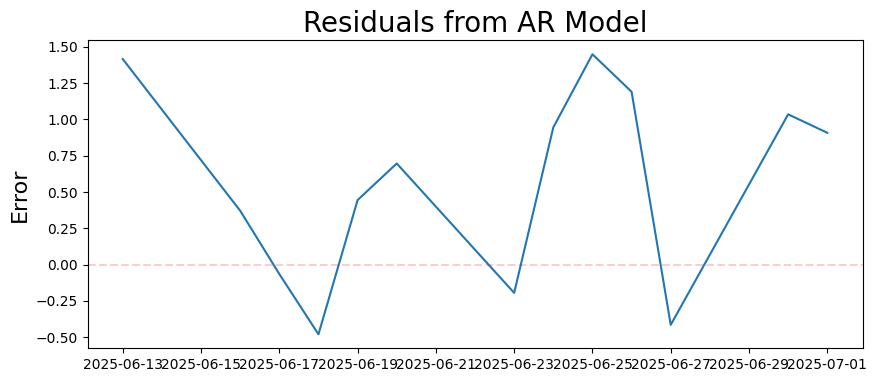

In [156]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)

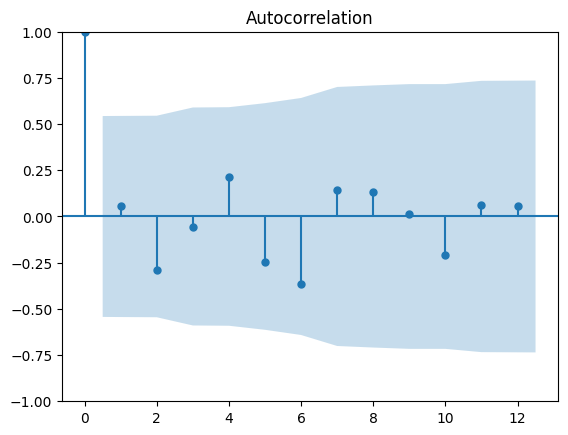

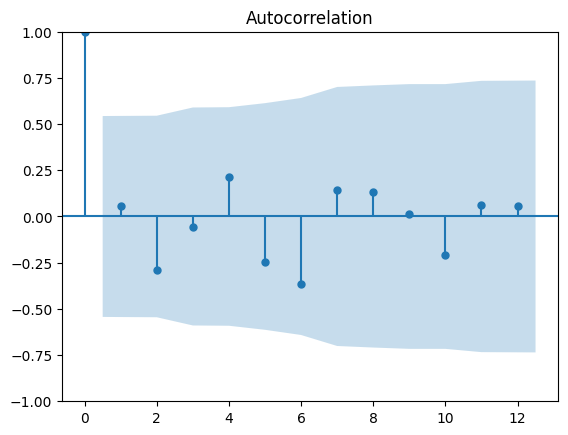

In [157]:
plot_acf(residuals_rolling,lags=12)

In [158]:
print('Mean Absolute Percent Error:',round(np.mean(abs(residuals_rolling/np.exp(test_data))),4))
print('Root Mean Squared Error:',np.sqrt(np.mean(residuals_rolling**2)))

Mean Absolute Percent Error: 0.0071
Root Mean Squared Error: 0.8581629127290838


RMSE: 0.8581629127290838
MAPE: 0.007106035070214594


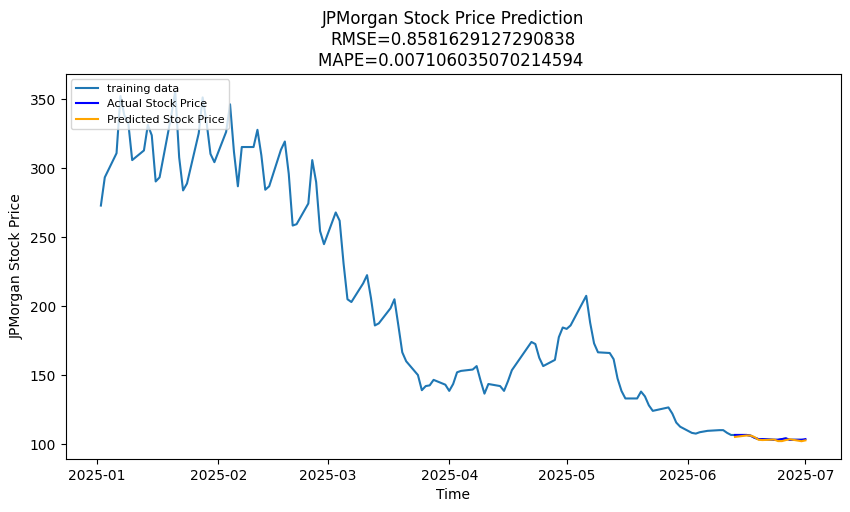

In [159]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(np.exp(predictions_rolling), color = 'orange',label='Predicted Stock Price')
#plt.fillbetween(test_data.index, lower_series, upper_series, color='k', alpha=.15)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(predictions_rolling)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(residuals_rolling)/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))
plt.title('JPMorgan Stock Price Prediction\nRMSE=%s\nMAPE=%s '%(str(rmse),str(mape)))
plt.xlabel('Time')
plt.ylabel('JPMorgan Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()